In [1]:
# To support both python 2 and python 3
from __future__ import print_function, division, unicode_literals
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

# Usual imports
import numpy as np
import os
import cv2
import warnings
from os.path import join as path_join
from tqdm import tqdm
import json
tqdm.pandas()
import itertools
from datetime import datetime

from itertools import combinations, product

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_columns", 100)

# while not os.getcwd().endswith("ml"):
#     os.chdir(os.path.abspath(os.path.join(os.pardir)))
print("Working dir:", os.getcwd())

from Common.analysis.analysis_tools import calculate_acceptable_precision_error
from Common.data_manipulation.pandas_tools import save_dataframe, add_face_id, load_df, separate_df_based_on_column_range, add_image_id
from Common.data_manipulation.dictionary_tools import convert_dict_lists_to_list_of_dicts, create_or_append_to_dict_of_lists, nested_dict_add_element

# from Common.paths.dataset_paths import 
from Common.image_tools.image_loading import load_image
from Common.image_tools.cropping import crop_box
from Common.image_tools.resizer import resize_image

from Common.data_manipulation.pickler import write_pickle, load_pickle

from Common.machine_learning_tools.model_tools.tensoflow_model_tools import initialize_memory_growth

from Common.miscellaneous import print_indexed_list, print_fraction, verbose_print
from Common.visualizations.image_visualizations import show_image, show_images, draw_pose, draw_bounding_box, draw_landmarks, draw_confidences
from Common.visualizations.figure_plotting import plot_histogram, plot_multiple_histograms, plot_scatter_historgram, plot_CED_curve, plot_multiple_CED_curves, plot_xy_curves, plot_xs_and_ys, plot_scatter_historgram

Working dir: D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT


In [2]:
experiments_path = path_join(os.getcwd(), "experiments")
data_filtering_path = path_join(os.getcwd(), "data_filtering")

In [3]:
train_csv_name = "training.csv"
results_csv_name = "results.csv"

MIN_CORRECT_LOSS = 0.3

In [4]:
def categorical_metric_analysis(df, categorical_columns, metric_column, do_plot_CDFs, marker=True, fig_size=(22, 8)):
    uniques = [sorted(pd.unique(df[categorical_column])) for categorical_column in categorical_columns]
    
    categorical_accuracies = {}

    if do_plot_CDFs:
        thresholds = np.linspace(0, 1, 51)
        cdfs = []
        cdfs_names = []
        
    for permutation in product(*uniques):
        print_string = ""

        unique_df = df.copy()
        for clmn, perm in zip(categorical_columns, permutation):
            unique_df = unique_df.loc[unique_df[clmn] == perm]

            print_string += "{}={} | ".format(clmn, perm)

        unique_size = len(unique_df)
        
        if unique_size == 0:
            continue
            
        mean_acc = unique_df[metric_column].mean()
        
        nested_dict_add_element(categorical_accuracies, permutation, mean_acc)
        
        if do_plot_CDFs:
            cdf = calculate_acceptable_precision_error(unique_df[metric_column], thresholds, absolute=True)
            cdfs.append(cdf)
            cdfs_names.append(print_string[:-3])

        print_string += "size: {:2d} | {}: {:.4f}".format(unique_size, metric_column, mean_acc)

        print(print_string)
        
    if do_plot_CDFs:
        plot_multiple_CED_curves(cdfs, thresholds, cdfs_names, axis_labels=['Tikslumas', "Tikimybė"], marker=marker, fig_size=fig_size)
        
    return categorical_accuracies

In [5]:
def df_to_dict_of_losses(df):
    dfs = dict(tuple(df.groupby('index')['loss']))
    dict_of_losses = {key: np.array(list(value)) for key, value in dfs.items()}
    
    return dict_of_losses

In [6]:
np.linspace(0, 1, 51)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [7]:
experiment_types = sorted(list(os.listdir(experiments_path)))
print_indexed_list(experiment_types)

0 CIFAR-10-LeNet
1 MNIST-LeNet1
2 MNIST-LeNet2
3 custom


In [66]:
experiment_type_idx = 0

experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx])
# experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx], "min_agreggation-fix")
# experiment_type_path = path_join(experiments_path, experiment_types[experiment_type_idx], "Stage 1")
experiments = sorted(list(os.listdir(experiment_type_path)))
print_indexed_list(experiments)

0 example_forgetting-ucb-k25-ftk3
1 example_forgetting-ucb-k25-ftk3-2
2 example_forgetting-ucb-k25-ftk3-3
3 example_forgetting-ucb-k25-ftk3-4
4 example_forgetting-ucb-k25-ftk3-5
5 example_forgetting-ucb-k25-ftk3-6
6 max_agreggation
7 min_agreggation
8 min_agreggation-2
9 min_agreggation-fix


In [67]:
exp_idx = 5

experiment_path = path_join(experiment_type_path, experiments[exp_idx])
experiment_path

'D:\\Igno\\Reikalingi\\KTU Magistras\\Magistrinis\\OoMLeT\\experiments\\CIFAR-10-LeNet\\example_forgetting-ucb-k25-ftk3-6'

# Training csv analysis

In [68]:
results_csv_name = "results.csv"
csv_fullname = path_join(experiment_path, results_csv_name)

res_df = load_df(csv_fullname)
res_df

Loaded a Dataframe with shape 6 × 14 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\example_forgetting-ucb-k25-ftk3-6\results.csv
at  2024-05-16 00:54:08.196796


,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size
0,0.015891,0.272104,2,24,64,72,120,344,elu,Dropout,0.1042,0.1000,20,45000
1,0.000331,0.885880,3,24,40,104,104,688,elu,None,0.2774,0.2762,16,45000
2,0.000719,0.826671,3,24,40,96,104,696,elu,None,0.3110,0.3084,16,45000
3,0.400000,0.319619,2,16,64,64,128,744,elu,None,0.0000,0.0000,2,45000
4,0.000100,1.000000,2,16,40,80,120,672,elu,None,0.1832,0.1820,14,45000
5,0.000100,1.000000,2,16,40,112,120,712,tanh,None,0.1812,0.1864,15,45000


In [69]:
res_df.head(60)

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size
0,0.015891,0.272104,2,24,64,72,120,344,elu,Dropout,0.1042,0.1000,20,45000
1,0.000331,0.885880,3,24,40,104,104,688,elu,None,0.2774,0.2762,16,45000
2,0.000719,0.826671,3,24,40,96,104,696,elu,None,0.3110,0.3084,16,45000
3,0.400000,0.319619,2,16,64,64,128,744,elu,None,0.0000,0.0000,2,45000
4,0.000100,1.000000,2,16,40,80,120,672,elu,None,0.1832,0.1820,14,45000
5,0.000100,1.000000,2,16,40,112,120,712,tanh,None,0.1812,0.1864,15,45000


In [70]:
res_df.sort_values('test_acc', ascending=False).head(60)

,learning_rate,l2_reg,window_size,conv1_depth,conv2_depth,conv3_depth,conv4_depth,fc_depth,activation,reg_method,val_acc,test_acc,time_spent,train_set_size
2,0.000719,0.826671,3,24,40,96,104,696,elu,None,0.3110,0.3084,16,45000
1,0.000331,0.885880,3,24,40,104,104,688,elu,None,0.2774,0.2762,16,45000
5,0.000100,1.000000,2,16,40,112,120,712,tanh,None,0.1812,0.1864,15,45000
4,0.000100,1.000000,2,16,40,80,120,672,elu,None,0.1832,0.1820,14,45000
0,0.015891,0.272104,2,24,64,72,120,344,elu,Dropout,0.1042,0.1000,20,45000
3,0.400000,0.319619,2,16,64,64,128,744,elu,None,0.0000,0.0000,2,45000


## concat training csvs

In [71]:
run_paths = sorted([le_dir for le_dir in os.listdir(experiment_path) if os.path.isdir(path_join(experiment_path, le_dir))])
run_paths

['0', '1', '2', '3', '4', '5']

In [72]:
dfs = []
good_indice = [2, 1, 5]

for run_path in good_indice:
    train_csv_fullname = path_join(experiment_path, str(run_path), train_csv_name)
    df = load_df(train_csv_fullname)
    df['run'] = int(run_path)
    
    dfs.append(df)
    
trainings_df = pd.concat(dfs)
trainings_df.sort_values(['run', 'epoch', 'step'], inplace=True)
trainings_df

Loaded a Dataframe with shape 225000 × 4 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\example_forgetting-ucb-k25-ftk3-6\2\training.csv
at  2024-05-16 00:54:25.802295
Loaded a Dataframe with shape 225000 × 4 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\example_forgetting-ucb-k25-ftk3-6\1\training.csv
at  2024-05-16 00:54:25.886295
Loaded a Dataframe with shape 225000 × 4 from D:\Igno\Reikalingi\KTU Magistras\Magistrinis\OoMLeT\experiments\CIFAR-10-LeNet\example_forgetting-ucb-k25-ftk3-6\5\training.csv
at  2024-05-16 00:54:25.964294


,epoch,step,index,loss,run
0,0,0,25920,2.426383,1
1,0,0,40480,2.779186,1
2,0,0,10503,2.831648,1
3,0,0,5628,4.989211,1
4,0,0,31585,4.242241,1
...,...,...,...,...,...
224995,4,43,24308,2.498712,5
224996,4,43,43336,2.462166,5
224997,4,43,33896,1.897983,5
224998,4,43,20162,2.061358,5


In [73]:
runs_sample_losses = {}

for good_run_idx in tqdm(good_indice):
    good_run_df = full_df.loc[full_df['run'] == good_run_idx]
    
    dict_of_losses = df_to_dict_of_losses(good_run_df)
    
    runs_sample_losses[good_run_idx] = dict_of_losses
    
print(runs_sample_losses.keys())
runs_sample_losses[good_indice[0]], runs_sample_losses[good_indice[-1]]

  0%|                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


NameError: name 'full_df' is not defined

In [279]:
# del runs_sample_losses[7]

## Example forgetting

Run 53 | val_acc: 0.7136 | test_acc: 0.5438
std: 6.911402750882921


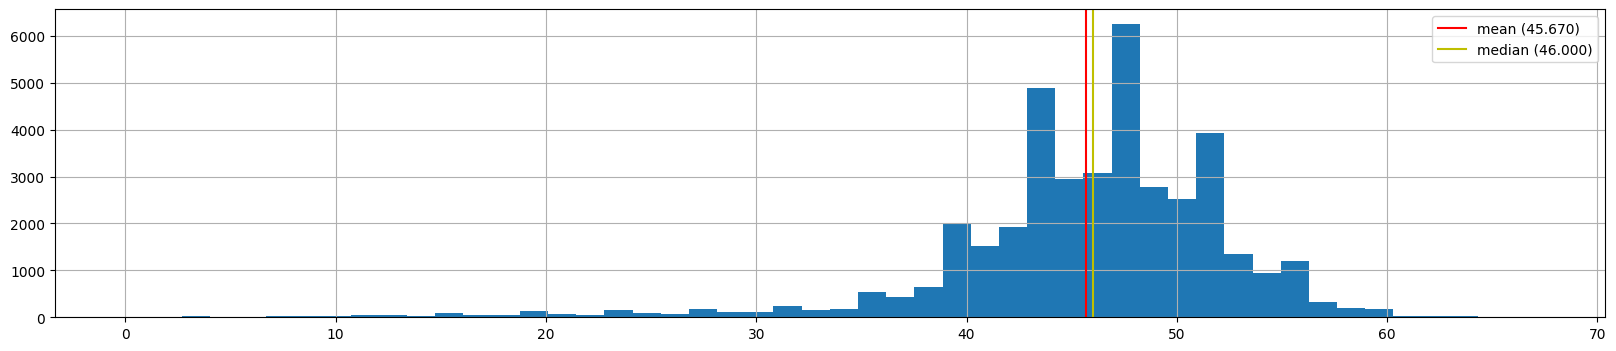

Run 61 | val_acc: 0.7016 | test_acc: 0.5373
std: 6.641488530669376


<Figure size 640x480 with 0 Axes>

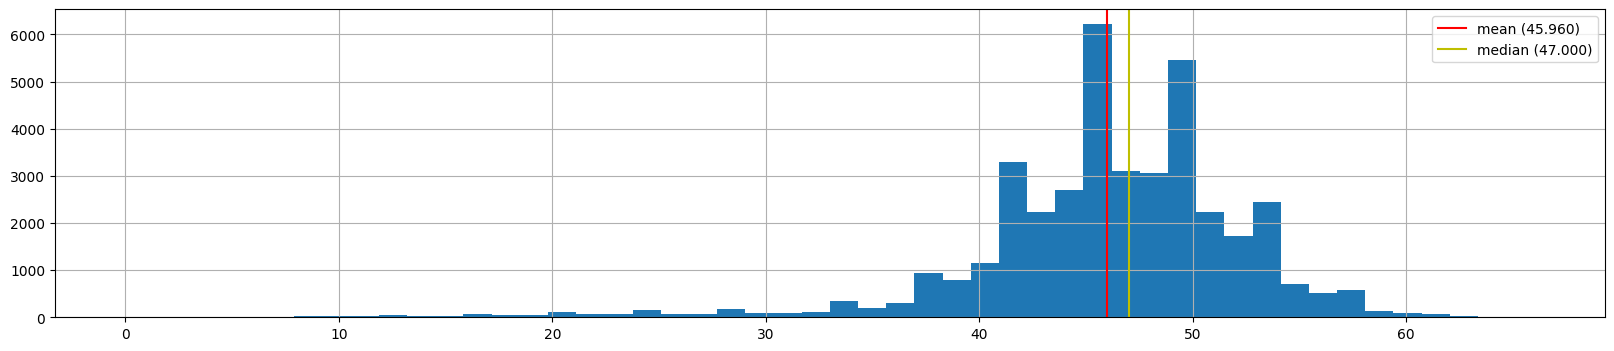

<Figure size 640x480 with 0 Axes>

In [182]:
runs_sample_forgetting = {}

for run_index, run_losses in runs_sample_losses.items():

    sample_forgetting = {}
    for sample_index, sample_losses in run_losses.items():
        forgetting_events = np.bitwise_and(sample_losses[:-1] < sample_losses[1:], sample_losses[1:] > MIN_CORRECT_LOSS)
        forgetting_events_count = np.sum(forgetting_events)

        sample_forgetting[sample_index] = forgetting_events_count
        create_or_append_to_dict_of_lists(runs_sample_forgetting, sample_index, forgetting_events_count)

    val_loss, test_loss = res_df.iloc[run_index][['val_acc', 'test_acc']]
    print("Run {} | val_acc: {:.4f} | test_acc: {:.4f}".format(run_index, val_loss, test_loss))
    plot_histogram(np.array(list(sample_forgetting.values())), fig_size=(20, 4))

In [183]:
runs_sample_forgetting

{0: [44, 60],
 1: [40, 42],
 3: [46, 34],
 4: [49, 47],
 5: [48, 48],
 6: [46, 50],
 8: [42, 26],
 9: [55, 46],
 10: [48, 38],
 11: [56, 47],
 12: [41, 48],
 13: [37, 47],
 14: [43, 44],
 15: [51, 51],
 16: [42, 38],
 17: [47, 43],
 18: [57, 47],
 20: [45, 44],
 21: [50, 54],
 22: [47, 46],
 23: [44, 46],
 24: [34, 44],
 25: [47, 50],
 26: [41, 47],
 27: [55, 51],
 28: [43, 34],
 29: [50, 47],
 30: [39, 41],
 31: [50, 54],
 33: [45, 43],
 34: [52, 45],
 35: [54, 48],
 36: [47, 49],
 38: [48, 45],
 39: [51, 48],
 40: [43, 58],
 41: [49, 49],
 42: [43, 42],
 44: [52, 49],
 47: [44, 43],
 49: [37, 43],
 50: [46, 44],
 51: [43, 40],
 52: [40, 49],
 53: [47, 45],
 54: [49, 33],
 55: [35, 48],
 56: [49, 46],
 57: [46, 44],
 58: [45, 53],
 59: [50, 43],
 60: [22, 40],
 61: [49, 50],
 63: [52, 49],
 65: [31, 38],
 66: [41, 48],
 67: [52, 46],
 69: [51, 43],
 70: [43, 45],
 71: [49, 48],
 72: [48, 57],
 73: [43, 49],
 74: [44, 43],
 75: [47, 47],
 76: [45, 47],
 77: [45, 43],
 78: [45, 41],
 79

std: 5.530737371271821


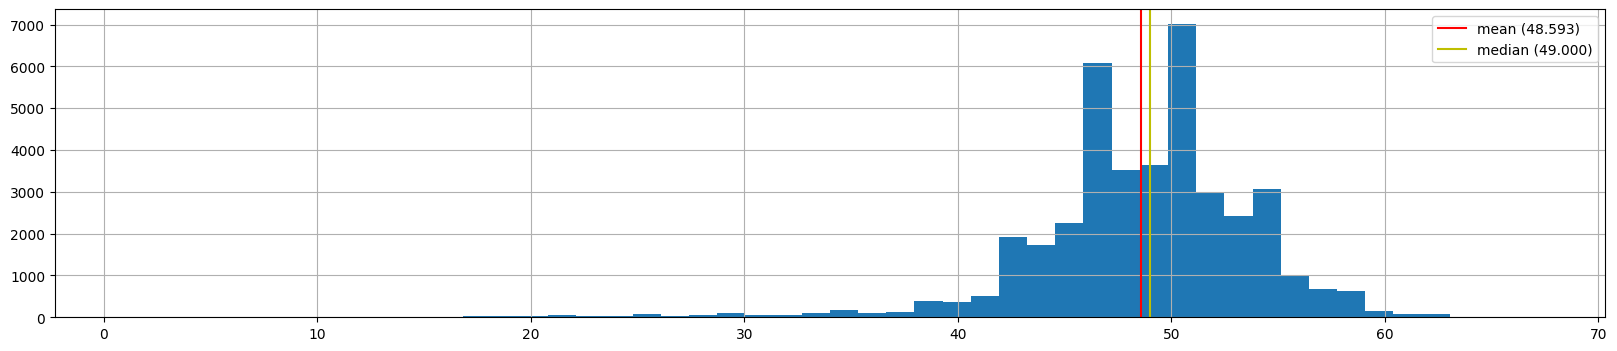

<Figure size 640x480 with 0 Axes>

In [184]:
runs_sample_max_forgets = {key: max(value) for key, value in runs_sample_forgetting.items()}
plot_histogram(np.array(list(runs_sample_max_forgets.values())), fig_size=(20, 4))

In [185]:
runs_sample_losses.keys()

dict_keys([53, 61])

In [186]:
runs_sample_forgetting_df = pd.DataFrame.from_dict(runs_sample_forgetting, orient='index', columns=runs_sample_losses.keys())
runs_sample_forgetting_df

,53,61
0,44,60
1,40,42
3,46,34
4,49,47
5,48,48
...,...,...
44995,43,41
44996,46,52
44997,46,47
44998,49,40


In [187]:
runs_sample_forgetting_df.sum()

53    1812589
61    1824110
dtype: int64

In [188]:
runs_sample_forgetting_df.corr()

,53,61
53,1.000000,0.402133
61,0.402133,1.000000


std: 5.530737371271821


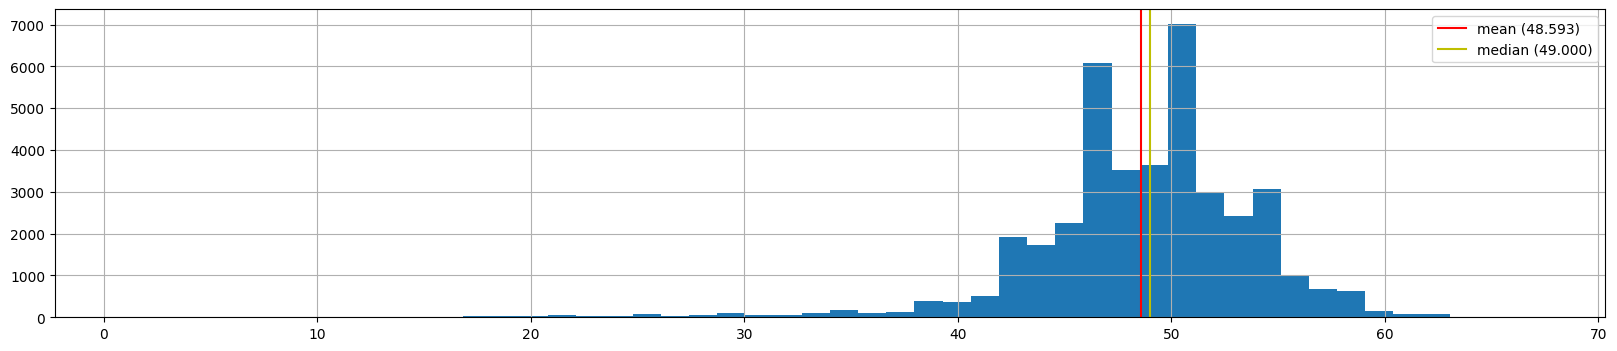

<Figure size 640x480 with 0 Axes>

In [189]:
max_forgets = runs_sample_forgetting_df.max(axis=1)
plot_histogram(max_forgets, fig_size=(20, 4))

In [288]:
# good_runs_sample_forgetting_df = runs_sample_forgetting_df[[1, 3, 5, 6, 8, 12, 17]]
# good_runs_sample_forgetting_df

In [190]:
unfergetful_samples = list(runs_sample_forgetting_df.loc[runs_sample_forgetting_df.max(axis=1) == 0].index)
len(unfergetful_samples), unfergetful_samples

(0, [])

In [190]:
26461 / 55000

0.48110909090909093

In [291]:
pickle_fullname = path_join(data_filtering_path, 'unforgetable_samples-40-1.pckl')
write_pickle(pickle_fullname, unfergetful_samples)

## Compare unforgetable samples

In [292]:
pckl_1_fullname = path_join(data_filtering_path, 'unforgetable_samples.pckl')
pckl_2_fullname = path_join(data_filtering_path, 'unforgetable_samples-25-1.pckl')
pckl_3_fullname = path_join(data_filtering_path, 'unforgetable_samples-40-1.pckl')

unfergetful_samples_1 = load_pickle(pckl_1_fullname)
unfergetful_samples_2 = load_pickle(pckl_2_fullname)
unfergetful_samples_3 = load_pickle(pckl_3_fullname)

len(unfergetful_samples_1), len(unfergetful_samples_2), len(unfergetful_samples_3)

(26461, 40551, 38492)

In [295]:
len(set(unfergetful_samples_1).intersection(unfergetful_samples_2).intersection(unfergetful_samples_3))

23683

In [296]:
len(set(unfergetful_samples_3).intersection(unfergetful_samples_2))

35225

In [297]:
55000 - 40551

14449

## First look hardness

In [74]:
trainings_df

,epoch,step,index,loss,run
0,0,0,25920,2.426383,1
1,0,0,40480,2.779186,1
2,0,0,10503,2.831648,1
3,0,0,5628,4.989211,1
4,0,0,31585,4.242241,1
...,...,...,...,...,...
224995,4,43,24308,2.498712,5
224996,4,43,43336,2.462166,5
224997,4,43,33896,1.897983,5
224998,4,43,20162,2.061358,5


In [89]:
le_df = trainings_df.loc[(trainings_df['run'] == 5) & (trainings_df['epoch'] == 0)]
le_df

,epoch,step,index,loss,run
0,0,0,31293,3.191597,5
1,0,0,36905,2.014229,5
2,0,0,18446,1.619956,5
3,0,0,38359,1.934479,5
4,0,0,3343,2.309816,5
...,...,...,...,...,...
44995,0,43,21563,2.398011,5
44996,0,43,21556,2.198354,5
44997,0,43,29661,2.284373,5
44998,0,43,41561,2.504674,5


In [97]:
le_df.drop_duplicates('index')

,epoch,step,index,loss,run
0,0,0,31293,3.191597,5
1,0,0,36905,2.014229,5
2,0,0,18446,1.619956,5
3,0,0,38359,1.934479,5
4,0,0,3343,2.309816,5
...,...,...,...,...,...
44990,0,43,9639,1.963464,5
44993,0,43,35899,1.884887,5
44996,0,43,21556,2.198354,5
44998,0,43,41561,2.504674,5


In [104]:
def trainings_df_to_dict_of_losses(trainings_df, only_first_epoch=False):
    runs_sample_losses = {}

    for run_idx in pd.unique(trainings_df['run']):
        df_mask = (trainings_df['run'] == run_idx) & (trainings_df['epoch'] == 0) if only_first_epoch else trainings_df['run'] == run_idx
        run_df = trainings_df.loc[df_mask]
        
        if only_first_epoch:
            run_df = run_df.drop_duplicates('index')

        index_to_loss_dict = df_to_dict_of_losses(run_df)

        runs_sample_losses[run_idx] = index_to_loss_dict

    return runs_sample_losses

In [105]:
runs_first_losses = trainings_df_to_dict_of_losses(trainings_df, True)
runs_first_losses[5]

{0: array([1.9181551]),
 1: array([2.6740704]),
 2: array([2.5130396]),
 3: array([3.9744825]),
 4: array([2.323091]),
 5: array([1.9654334]),
 6: array([2.2419884]),
 7: array([2.6180363]),
 8: array([2.0292616]),
 9: array([2.13116]),
 10: array([3.7803698]),
 11: array([2.184094]),
 12: array([2.064274]),
 13: array([3.183061]),
 14: array([2.8146076]),
 19: array([2.5518684]),
 20: array([2.843224]),
 21: array([2.1296268]),
 24: array([2.4108572]),
 26: array([1.9736738]),
 27: array([2.0865781]),
 31: array([2.480732]),
 32: array([1.6818869]),
 34: array([3.5921345]),
 35: array([2.384879]),
 37: array([2.600664]),
 38: array([2.6366444]),
 39: array([1.7293851]),
 41: array([2.3635225]),
 42: array([2.050501]),
 43: array([2.4408817]),
 44: array([2.0979695]),
 46: array([2.2410371]),
 47: array([2.763031]),
 49: array([2.49981]),
 50: array([2.793074]),
 51: array([2.2860074]),
 52: array([2.6447487]),
 53: array([2.7791257]),
 54: array([3.132454]),
 55: array([2.6059306]),
 

In [75]:
only_first_epoch = True

runs_first_losses = {}

for good_run_idx in tqdm(good_indice):
    df_mask = (trainings_df['run'] == good_run_idx) & (trainings_df['epoch'] == 0) if only_first_epoch else trainings_df['run'] == good_run_idx
    good_trainings_df = trainings_df.loc[df_mask]  #  & (trainings_df['epoch'] == 0)
#     print(max(pd.value_counts(good_trainings_df['index'])))
    
    dict_of_losses = df_to_dict_of_losses(good_trainings_df)
    
    runs_first_losses[good_run_idx] = dict_of_losses
    
print(runs_first_losses.keys())
runs_first_losses[good_indice[0]], runs_first_losses[good_indice[-1]]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]

dict_keys([2, 1, 5])


({0: array([1.8484609]),
  1: array([2.4296374]),
  2: array([0.8952658]),
  3: array([2.3632514]),
  4: array([1.8615358]),
  5: array([4.910898]),
  6: array([2.1082926]),
  7: array([3.6972973]),
  8: array([3.3692222]),
  9: array([3.507989]),
  10: array([4.3996086]),
  11: array([3.2472405]),
  12: array([2.538648]),
  13: array([1.8638831]),
  14: array([1.5325428]),
  15: array([3.9081788]),
  16: array([1.1085943]),
  17: array([2.0568886]),
  18: array([7.9516096]),
  19: array([2.9558072]),
  20: array([3.3986764]),
  21: array([1.8422039]),
  22: array([2.1437855]),
  23: array([2.593768]),
  24: array([3.1831698]),
  25: array([3.1304517]),
  26: array([2.1586123]),
  27: array([2.2915506]),
  28: array([1.629078]),
  29: array([3.3425584]),
  30: array([0.48038456]),
  31: array([5.9017467]),
  32: array([3.0414424]),
  33: array([2.0951996]),
  34: array([2.9177983]),
  35: array([4.0026712]),
  36: array([2.7913103]),
  37: array([2.1971898]),
  38: array([5.5943613]),


In [79]:
runs_first_losses[5]

{0: array([1.9181551]),
 1: array([2.6740704, 2.349389 ]),
 2: array([2.5130396]),
 3: array([3.9744825]),
 4: array([2.323091]),
 5: array([1.9654334]),
 6: array([2.2419884]),
 7: array([2.6180363]),
 8: array([2.0292616]),
 9: array([2.13116]),
 10: array([3.7803698]),
 11: array([2.184094]),
 12: array([2.064274]),
 13: array([3.183061 , 2.9027958]),
 14: array([2.8146076, 2.552081 ]),
 19: array([2.5518684, 2.565693 ]),
 20: array([2.843224]),
 21: array([2.1296268, 2.3726292]),
 24: array([2.4108572, 2.2097042]),
 26: array([1.9736738]),
 27: array([2.0865781]),
 31: array([2.480732 , 2.0880382]),
 32: array([1.6818869]),
 34: array([3.5921345]),
 35: array([2.384879]),
 37: array([2.600664]),
 38: array([2.6366444]),
 39: array([1.7293851]),
 41: array([2.3635225]),
 42: array([2.050501]),
 43: array([2.4408817, 2.2691236]),
 44: array([2.0979695, 2.5311377]),
 46: array([2.2410371]),
 47: array([2.763031 , 2.2516022]),
 49: array([2.49981]),
 50: array([2.793074]),
 51: array([

In [106]:
def get_samples_runs_first_losses(runs_first_losses):
    samples_runs_first_loss = {}

    for run_index, run_losses in runs_first_losses.items():
        for sample_index, sample_loss in run_losses.items():
            create_or_append_to_dict_of_lists(samples_runs_first_loss, sample_index, sample_loss)

    samples_runs_first_loss = {key: np.squeeze(values) for key, values in samples_runs_first_loss.items()}

    return samples_runs_first_loss

In [107]:
samples_runs_first_loss = {}
runs_samples_first_loss = {}

for run_index, run_losses in runs_first_losses.items():
    samples_first_loss = {}

    for sample_index, sample_loss in run_losses.items():
        samples_first_loss[sample_index] = sample_loss
        
        create_or_append_to_dict_of_lists(samples_runs_first_loss, sample_index, sample_loss)

    runs_samples_first_loss[run_index] = samples_first_loss
    
samples_runs_first_loss = {key: np.squeeze(values) for key, values in samples_runs_first_loss.items()}

runs_samples_first_loss, samples_runs_first_loss

({1: {0: array([1.983315]),
   1: array([1.0583696]),
   2: array([5.7152143]),
   3: array([2.4863384]),
   4: array([2.8225627]),
   5: array([1.6717455]),
   6: array([2.467083]),
   7: array([2.2419658]),
   8: array([2.4278822]),
   9: array([3.3159654]),
   10: array([2.1524148]),
   11: array([1.5785843]),
   12: array([2.591692]),
   13: array([2.6811924]),
   14: array([2.01581]),
   15: array([5.8047647]),
   16: array([2.9777596]),
   17: array([2.1358593]),
   18: array([2.741344]),
   19: array([2.2610924]),
   20: array([1.5481865]),
   21: array([1.5590035]),
   22: array([2.2555113]),
   23: array([2.1141057]),
   24: array([2.404898]),
   25: array([3.2036703]),
   26: array([3.262138]),
   27: array([1.8759809]),
   28: array([2.075408]),
   29: array([2.9084115]),
   30: array([1.9034183]),
   31: array([1.049153]),
   32: array([2.2038915]),
   33: array([2.2521667]),
   34: array([3.107225]),
   35: array([2.281388]),
   36: array([1.6388707]),
   37: array([2.1096

In [108]:
samples_runs_first_loss

{0: array([1.983315 , 1.8484609, 1.9181551]),
 1: array([1.0583696, 2.4296374, 2.6740704]),
 2: array([5.7152143, 0.8952658, 2.5130396]),
 3: array([2.4863384, 2.3632514, 3.9744825]),
 4: array([2.8225627, 1.8615358, 2.323091 ]),
 5: array([1.6717455, 4.910898 , 1.9654334]),
 6: array([2.467083 , 2.1082926, 2.2419884]),
 7: array([2.2419658, 3.6972973, 2.6180363]),
 8: array([2.4278822, 3.3692222, 2.0292616]),
 9: array([3.3159654, 3.507989 , 2.13116  ]),
 10: array([2.1524148, 4.3996086, 3.7803698]),
 11: array([1.5785843, 3.2472405, 2.184094 ]),
 12: array([2.591692, 2.538648, 2.064274]),
 13: array([2.6811924, 1.8638831, 3.183061 ]),
 14: array([2.01581  , 1.5325428, 2.8146076]),
 15: array([5.8047647, 3.9081788]),
 16: array([2.9777596, 1.1085943]),
 17: array([2.1358593, 2.0568886]),
 18: array([2.741344 , 7.9516096]),
 19: array([2.2610924, 2.9558072, 2.5518684]),
 20: array([1.5481865, 3.3986764, 2.843224 ]),
 21: array([1.5590035, 1.8422039, 2.1296268]),
 22: array([2.2555113, 

In [109]:
samples_runs_first_loss = get_samples_runs_first_losses(runs_first_losses)
samples_runs_first_loss

{0: array([1.983315 , 1.8484609, 1.9181551]),
 1: array([1.0583696, 2.4296374, 2.6740704]),
 2: array([5.7152143, 0.8952658, 2.5130396]),
 3: array([2.4863384, 2.3632514, 3.9744825]),
 4: array([2.8225627, 1.8615358, 2.323091 ]),
 5: array([1.6717455, 4.910898 , 1.9654334]),
 6: array([2.467083 , 2.1082926, 2.2419884]),
 7: array([2.2419658, 3.6972973, 2.6180363]),
 8: array([2.4278822, 3.3692222, 2.0292616]),
 9: array([3.3159654, 3.507989 , 2.13116  ]),
 10: array([2.1524148, 4.3996086, 3.7803698]),
 11: array([1.5785843, 3.2472405, 2.184094 ]),
 12: array([2.591692, 2.538648, 2.064274]),
 13: array([2.6811924, 1.8638831, 3.183061 ]),
 14: array([2.01581  , 1.5325428, 2.8146076]),
 15: array([5.8047647, 3.9081788]),
 16: array([2.9777596, 1.1085943]),
 17: array([2.1358593, 2.0568886]),
 18: array([2.741344 , 7.9516096]),
 19: array([2.2610924, 2.9558072, 2.5518684]),
 20: array([1.5481865, 3.3986764, 2.843224 ]),
 21: array([1.5590035, 1.8422039, 2.1296268]),
 22: array([2.2555113, 

std: 1.3816217059339333


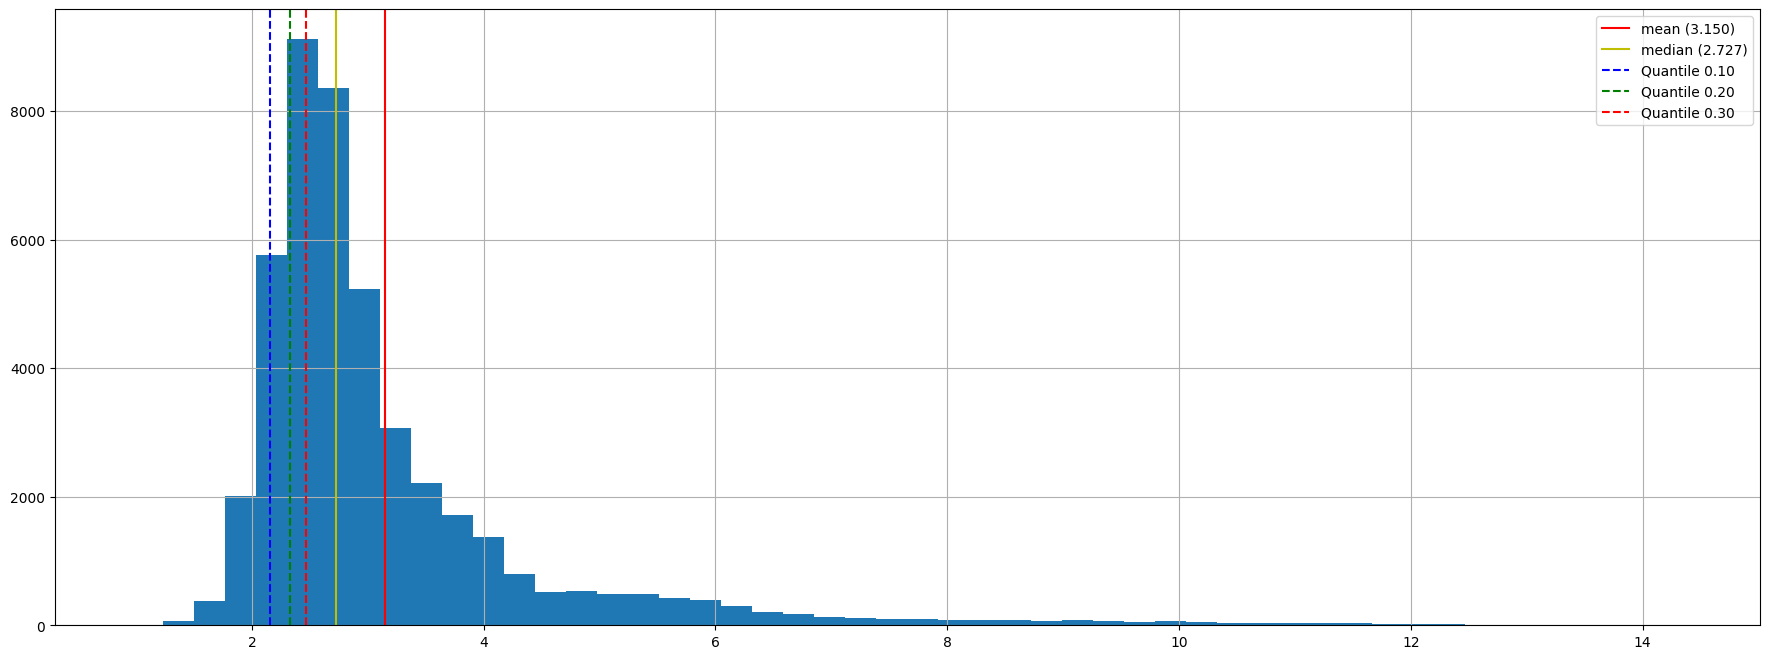

std: 0.43550071247690886


<Figure size 640x480 with 0 Axes>

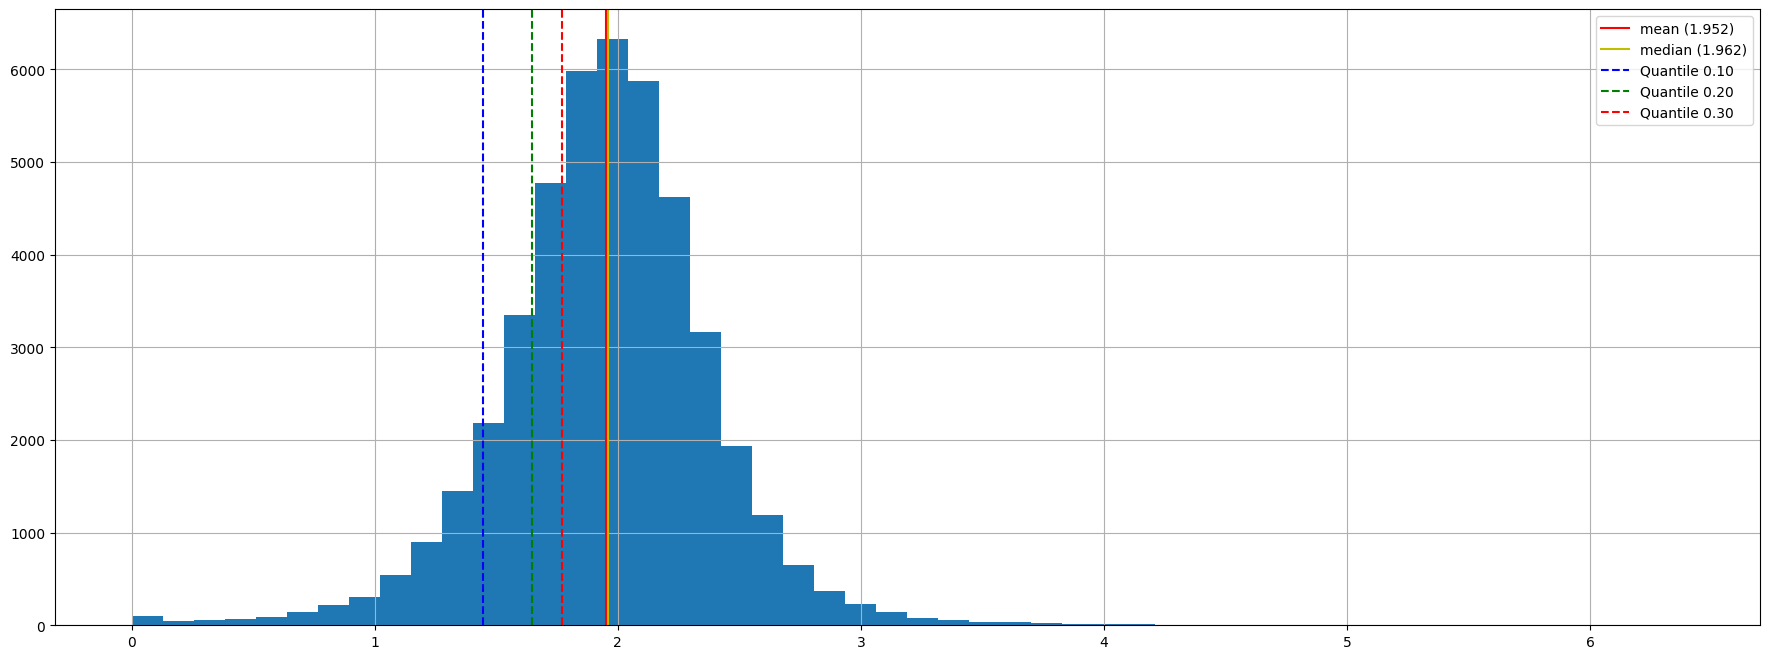

<Figure size 640x480 with 0 Axes>

In [110]:
max_samples_runs_first_loss = np.array([[key, np.max(values)] for key, values in samples_runs_first_loss.items()])
min_samples_runs_first_loss = np.array([[key, np.min(values)] for key, values in samples_runs_first_loss.items()])

plot_histogram(max_samples_runs_first_loss[:, 1], add_quatinles=[0.1, 0.2, 0.3])
plot_histogram(min_samples_runs_first_loss[:, 1], add_quatinles=[0.1, 0.2, 0.3])

In [60]:
filtered_max_losses = max_samples_runs_first_loss[max_samples_runs_first_loss[:, 1] < MIN_CORRECT_LOSS]
filtered_min_losses = min_samples_runs_first_loss[min_samples_runs_first_loss[:, 1] < MIN_CORRECT_LOSS]
filtered_max_losses.shape, filtered_min_losses.shape

((2, 2), (89, 2))

In [61]:
unforgettable_samples = filtered_min_losses[:, 0].astype(int)
unforgettable_samples

array([  221,   883,  1233,  1437,  1975,  2020,  2352,  3773,  3842,
        4111,  4348,  4645,  4689,  5203,  5637,  7409,  7441,  7599,
        7687,  7925,  8292,  9881, 10316, 10332, 11128, 11244, 11979,
       12030, 12210, 13346, 13538, 13968, 14931, 15553, 15951, 17792,
       20089, 20242, 20559, 20622, 21713, 22186, 22623, 23936, 24396,
       26338, 26783, 26875, 26952, 27249, 27646, 27693, 28166, 28178,
       28882, 28900, 29057, 29142, 29275, 29822, 30676, 30968, 31031,
       31715, 32252, 32363, 32968, 32990, 33007, 33368, 33930, 34456,
       34562, 34792, 35518, 35789, 35885, 38778, 38868, 39841, 40030,
       40157, 40839, 41164, 43047, 43086, 43131, 43149, 43535])

#### Load filtered

In [32]:
experiment_path

'D:\\Igno\\Reikalingi\\KTU Magistras\\Magistrinis\\OoMLeT\\experiments\\CIFAR-10-LeNet\\min_agreggation-fix\\example_forgetting-ucb-k25-ftk2'

In [33]:
pckl_fullname = path_join(experiment_path, 'unforgettable_samples-95.pckl')

unforgettable_samples_loaded = load_pickle(pckl_fullname)

len(unforgettable_samples_loaded)

599

In [34]:
unforgettable_samples_loaded

[117,
 139,
 190,
 201,
 396,
 534,
 566,
 634,
 943,
 976,
 1233,
 1268,
 1329,
 1477,
 1485,
 1562,
 1604,
 1673,
 1683,
 1729,
 1996,
 2283,
 2566,
 2592,
 2597,
 2658,
 2909,
 2928,
 2975,
 3232,
 3387,
 3409,
 3516,
 3523,
 3666,
 3682,
 3741,
 3789,
 3833,
 3942,
 4090,
 4236,
 4264,
 4407,
 4575,
 4589,
 4704,
 4713,
 4949,
 5145,
 5374,
 5708,
 5841,
 5941,
 5951,
 5958,
 5987,
 6276,
 6300,
 6508,
 6775,
 6942,
 7169,
 7202,
 7256,
 7292,
 7414,
 7587,
 7591,
 8138,
 8175,
 8369,
 8421,
 8512,
 8532,
 8570,
 9122,
 9144,
 9271,
 9358,
 9376,
 9427,
 9481,
 9616,
 9689,
 9773,
 10064,
 10098,
 10233,
 10317,
 10375,
 10455,
 10730,
 10965,
 10969,
 11049,
 11114,
 11265,
 11266,
 11410,
 11501,
 11661,
 11715,
 11733,
 11908,
 12172,
 12385,
 12432,
 12807,
 12893,
 13135,
 13188,
 13197,
 13246,
 13350,
 13376,
 13420,
 13516,
 13674,
 13731,
 13888,
 13947,
 14123,
 14207,
 14245,
 14281,
 14389,
 14431,
 14501,
 14683,
 14951,
 15013,
 15025,
 15045,
 15071,
 15100,
 15174,


In [35]:
overlap = set(unforgettable_samples_loaded).intersection(unforgettable_samples)
len(overlap)

4

In [453]:
overlap

{1233, 24396, 40157, 43149}

In [459]:
trainings_df.loc[(trainings_df['index'].isin(overlap)) & (trainings_df['epoch'] == 0)]

,epoch,step,index,loss,run
5462,0,5,24396,1.652731,50
16403,0,16,1233,0.273360,50
32741,0,31,40157,0.873286,50
41320,0,40,43149,0.660206,50
1532,0,1,1233,1.195477,95
24235,0,23,43149,0.252866,95
36706,0,35,40157,0.219541,95
39773,0,38,24396,0.282248,95


In [47]:
for run_idx_1 in first_look_df.columns:
    for run_idx_2 in first_look_df.columns:
        if run_idx_1 < run_idx_2:
            overlap = len(set(runs_filtered_indice[run_idx_1]).intersection(runs_filtered_indice[run_idx_2]))
            
            print("Overlap between {:2d} and {:2d} : {} ({:.3f})".format(run_idx_1, run_idx_2, overlap, overlap/len(runs_filtered_indice[run_idx_1])))

Overlap between  1 and  3 : 821 (0.284)
Overlap between  1 and  4 : 856 (0.296)
Overlap between  1 and  6 : 879 (0.304)
Overlap between  1 and  8 : 810 (0.280)
Overlap between  1 and 12 : 859 (0.297)
Overlap between  1 and 22 : 795 (0.275)
Overlap between  1 and 25 : 856 (0.296)
Overlap between  1 and 26 : 697 (0.241)
Overlap between  1 and 27 : 892 (0.309)
Overlap between  3 and  4 : 862 (0.298)
Overlap between  3 and  6 : 856 (0.296)
Overlap between  3 and  8 : 897 (0.310)
Overlap between  3 and 12 : 869 (0.301)
Overlap between  3 and 22 : 816 (0.282)
Overlap between  3 and 25 : 920 (0.318)
Overlap between  3 and 26 : 807 (0.279)
Overlap between  3 and 27 : 1013 (0.351)
Overlap between  4 and  6 : 967 (0.335)
Overlap between  4 and  8 : 844 (0.292)
Overlap between  4 and 12 : 922 (0.319)
Overlap between  4 and 22 : 926 (0.320)
Overlap between  4 and 25 : 1019 (0.353)
Overlap between  4 and 26 : 758 (0.262)
Overlap between  4 and 27 : 941 (0.326)
Overlap between  6 and  8 : 833 (0.288

In [48]:
len(set(runs_filtered_indice[1]).intersection(runs_filtered_indice[3]).intersection(runs_filtered_indice[4]))

301

In [51]:
first_look_df.min(axis=1)

0        0.049894
20       0.000061
22       0.514242
24       0.027219
25       0.003658
           ...   
54983    0.140895
54985    0.000506
54986    0.334403
54992    0.100989
54994    0.019061
Length: 14449, dtype: float64

std: 0.3075834973152293


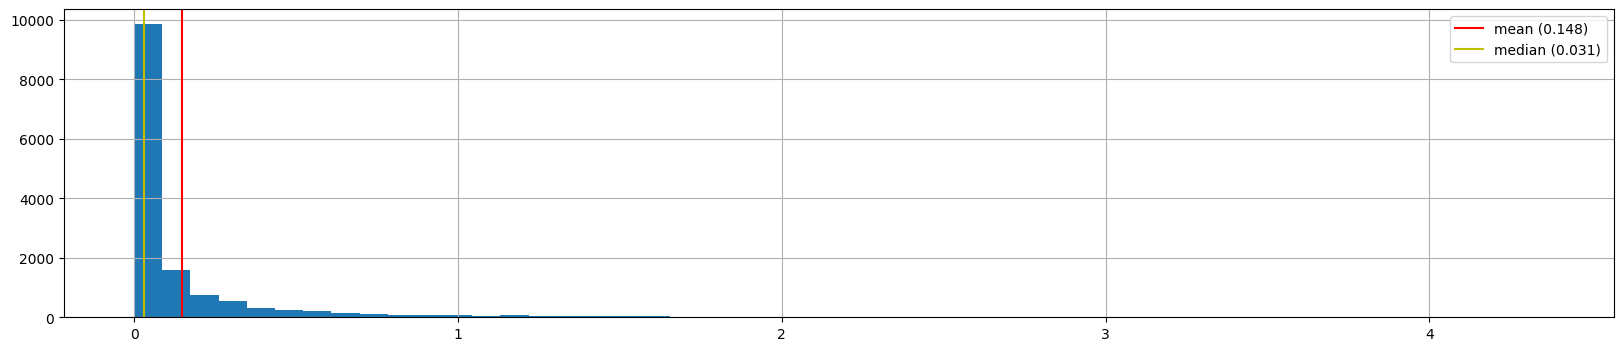

<Figure size 640x480 with 0 Axes>

In [52]:
plot_histogram(first_look_df.min(axis=1), fig_size=(20, 4))